Step 1: Loading preprocessed training and test data...
Preprocessed Training data shape: (891, 25)
Preprocessed Test data shape: (418, 24)

First 3 rows of preprocessed training 
   PassengerId       Age      Fare  FamilySize  IsAlone  Sex_male  Embarked_Q  \
0            1 -0.563707 -0.503176           2        0      True       False   
1            2  0.653100  0.734809           2        0     False       False   
2            3 -0.259505 -0.490126           1        1     False       False   

   Embarked_S  Pclass_2  Pclass_3  ...  Title_Royalty  Deck_B  Deck_C  Deck_D  \
0        True     False      True  ...          False   False   False   False   
1       False     False     False  ...          False   False    True   False   
2        True     False      True  ...          False   False   False   False   

   Deck_E  Deck_F  Deck_G  Deck_T  Deck_U  Survived  
0   False   False   False   False    True         0  
1   False   False   False   False   False         1  
2   False

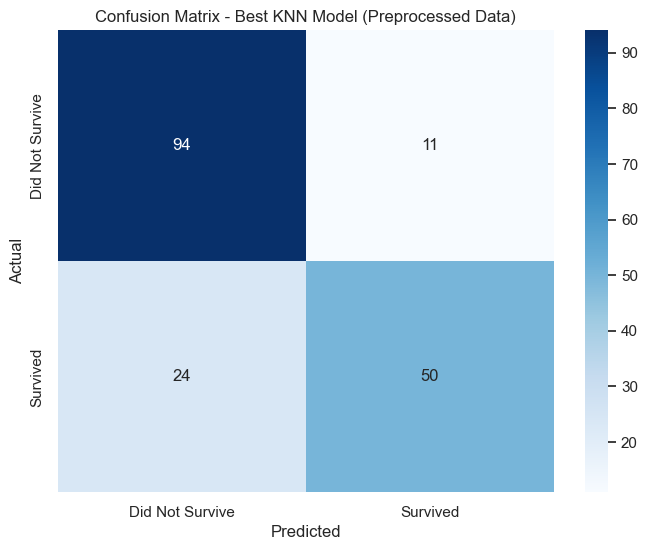


Step 7: Training final model on full training data and making test predictions...

Final submission file created: knn_submission_preprocessed.csv
Shape of submission: (418, 2)
First 10 predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

Final model saved as 'final_knn_model_preprocessed.pkl'

KNN model training and prediction (on preprocessed data) complete!
The 'knn_submission_preprocessed.csv' file is ready for submission.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- Step 1: Load the Preprocessed Training and Test Data ---
print("Step 1: Loading preprocessed training and test data...")
# Use the correct filenames based on your uploads
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

# Save passenger IDs for the final submission
test_passenger_ids = test['PassengerId'].copy()

# Display basic information
print(f"Preprocessed Training data shape: {train.shape}")
print(f"Preprocessed Test data shape: {test.shape}")
print(f"\nFirst 3 rows of preprocessed training ")
print(train.head(3))
print(f"\nFirst 3 rows of preprocessed test ")
print(test.head(3))

# --- Step 2: Prepare Features and Target from Training Data ---
print("\nStep 2: Preparing features and target from training data...")

# Assuming the last column is 'Survived' and the first column is 'PassengerId'
# Adjust column names if they are different in your actual files
X_train_full = train.drop(['PassengerId', 'Survived'], axis=1) # Features are everything except PassengerId and Survived
y_train_full = train['Survived'] # Target is Survived

# Features for the test set (everything except PassengerId)
X_test = test.drop(['PassengerId'], axis=1)

print(f"Features shape (X_train_full): {X_train_full.shape}")
print(f"Target shape (y_train_full): {y_train_full.shape}")
print(f"Test features shape (X_test): {X_test.shape}")
print(f"Features used for training: {list(X_train_full.columns)}")

# --- Step 3: Split Training Data for Validation ---
print("\nStep 3: Splitting training data for validation...")
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# --- Step 4: Define the Model Pipeline (No preprocessing needed as data is already preprocessed) ---
print("\nStep 4: Defining the model pipeline (no preprocessing required)...")

# Since the data is already preprocessed (standardized, encoded), we don't need a preprocessor in the pipeline
# Just the classifier is needed
knn_model = Pipeline([
    # ('preprocessor', preprocessor), # No preprocessor needed here
    ('classifier', KNeighborsClassifier())
])

# --- Step 5: Train the KNN Model with Hyperparameter Tuning ---
print("\nStep 5: Training and tuning the KNN model...")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [2, 4, 6, 8, 10, 12],      # Different k values
    'classifier__weights': ['uniform', 'distance'],       # Keep these
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'] # Add minkowski
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=3,                    # Number of cross-validation folds (reduced for speed)
    scoring='accuracy',
    n_jobs=-1,               # Use all available processors
    verbose=1                # Print progress
)

# Fit the GridSearchCV (this trains many models with different parameters)
# The data is already preprocessed, so we pass X_train and y_train directly
grid_search.fit(X_train, y_train)

# Get the best model
best_knn_model = grid_search.best_estimator_
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# --- Step 6: Evaluate the Best Model on Validation Set ---
print("\nStep 6: Evaluating the best model on the validation set...")

# Make predictions on the validation set
y_pred = best_knn_model.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Print a detailed classification report
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Did Not Survive', 'Survived'],
           yticklabels=['Did Not Survive', 'Survived'])
plt.title('Confusion Matrix - Best KNN Model (Preprocessed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Step 7: Train Final Model on Full Training Data and Make Test Predictions ---
print("\nStep 7: Training final model on full training data and making test predictions...")

# Train the best model configuration on the *entire* preprocessed training dataset
# This is the final model used for the competition submission
final_model = grid_search.best_estimator_
final_model.fit(X_train_full, y_train_full) # Use the full preprocessed training data

# Make predictions on the preprocessed test set
test_predictions = final_model.predict(X_test)

# Create the final submission file
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': test_predictions
})

# Save the submission file
submission.to_csv('knn_submission_preprocessed.csv', index=False)
print(f"\nFinal submission file created: knn_submission_preprocessed.csv")
print(f"Shape of submission: {submission.shape}")
print(f"First 10 predictions:")
print(submission.head(10))

# --- Step 8: Save the Final Trained Model ---
import joblib
joblib.dump(final_model, 'final_knn_model_preprocessed.pkl')
print("\nFinal model saved as 'final_knn_model_preprocessed.pkl'")

print("\nKNN model training and prediction (on preprocessed data) complete!")
print("The 'knn_submission_preprocessed.csv' file is ready for submission.")

In [ ]:
#inital parameter tuning process

# param_grid = {
#     'classifier__n_neighbors': [3, 5, 7, 9, 11],      # Number of neighbors
#     'classifier__weights': ['uniform', 'distance'],    # Weight function used in prediction
#     'classifier__metric': ['euclidean', 'manhattan']   # Distance metric
# }
#Accuracy: 89%

# param_grid = {
#     'classifier__n_neighbors': [2, 4, 6, 8, 10, 12],      # Different k values
#     'classifier__weights': ['uniform', 'distance'],       # Keep these
#     'classifier__metric': ['euclidean', 'manhattan', 'minkowski'] # Add minkowski
# }
#Accuracy: 88.28%

#Seems like the preprocessed data is slightly worse than the previous model with built in preprocessing